<a href="https://colab.research.google.com/github/atjessehill/Thesis-Notebooks/blob/main/Music_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
from os import path
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from sklearn import preprocessing
import statistics
from keras import backend as K
import scipy
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
keras.backend.clear_session()

In [ ]:
BASE = 'drive/My Drive'
SONG_SAMPLE_PATH = 'Thesis/Samples'
DATA_SAVE_PATH = 'Thesis/InputData'

In [ ]:
def load_npy(path, tab):
  x_train = np.load(os.path.join(path,'x_train_'+str(tab)+'.npy'))
  x_test = np.load(os.path.join(path,'x_test_'+str(tab)+'.npy'))
  y_train = np.load(os.path.join(path,'y_train_'+str(tab)+'.npy'))
  y_test = np.load(os.path.join(path,'y_test_'+str(tab)+'.npy'))
  x_train = x_train[..., np.newaxis]
  x_test = x_test[..., np.newaxis]
  return x_train, x_test, y_train, y_test
  # imgs_validate = np.load('imgs_validate.npy')

In [ ]:
def rescale_data():
  scaler = preprocessing.MinMaxScaler()
  mfcc = []
  i = 0
  for i, (d) in enumerate(data['mfcc']):
    scaler.fit(d)
    transform = scaler.transform(d)
    mfcc.append(transform)
  x = np.array(mfcc)
  y = np.array(data['labels'])

    # preprocessing.scale(x)
    # preprocessing.scale(y)

  return x, y

def load_auto(path):
  with open(os.path.join(BASE, DATA_SAVE_PATH, path), 'r') as fp:
    data = json.load(fp)
  x = np.empty(shape=(len(data['mfcc']), 18))
  y = np.empty(shape=(len(data['labels']), 1))
  for i in data['mfcc']:
    np.append(x, np.array(i))

  for i in data['lables']:
    np.append(y, )

  

  x = np.array()
  y = np.array()


# path to images dataset. Recommended to write down entire path to avoid errors (i.e "C:/User/Desktop.../raw/)
def load_data(path):
  with open(os.path.join(BASE, DATA_SAVE_PATH, path), 'r') as fp:
    data = json.load(fp)

  x = np.array(data['mfcc'])
  y = np.array(data['labels'])
  return x, y

def load_splits():
  with open(os.path.join(BASE, DATA_SAVE_PATH, '10-fold-splits.json'), 'r') as fp:
    data = json.load(fp)

  return data


def prepare_datasets(path, test_size, validation_size=None, cnn=False):

  data = {}
  X, y = load_npy(path)
  # create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  if validation_size:
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

  if cnn:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    if validation_size:
      X_validation = X_validation[..., np.newaxis]

  data['X_train'] = X_train
  data['X_test'] = X_test
  data['y_train'] = y_train
  data['y_test'] = y_test

  if validation_size:
    data['X_validation'] = X_validation
    data['y_validation'] = y_validation

  return data

In [ ]:
def build_cnn_v2(input_shape):

  model = keras.Sequential()

  #1st conv layer
  # horizontal layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  # vertical
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((4, 1), strides=(4, 1), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #3rd conv layer
  # second 2x2
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here
  model.add(keras.layers.Dense(1024, activation='relu'))
  # model.add(keras.layers.Dense(512, activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def build_cnn(input_shape):

  model = keras.Sequential()

  #1st conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #3rd conv layer
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here

  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def build_model(input_shape):

  model = keras.Sequential()

  model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(256))

  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))

  model.add(keras.layers.Dropout(0.30))

  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(5, 5))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="upper left")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper left")
    axs[1].set_title("Error eval")
    # plt.figure(figsize=(30,30))
    plt.show()

In [ ]:
def run_cnn(X_train, X_test, y_train, y_test):
  #X_train, X_test, X_validation, y_train, y_test, y_validation = prepare_datasets_cnn(0.25, 0.10)
  print(X_train.shape)
  print(X_test.shape)
  print(y_train.shape)
  print(y_test.shape)
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  # input_shape = (X_train.shape[1], X_train.shape[2])
  model = build_cnn_v2(input_shape)
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  weights = os.path.join(BASE, 'Thesis', 'weights.h5')
  callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0, mode='max'), keras.callbacks.ModelCheckpoint(weights, monitor='val_accuracy', mode='max', save_best_only=True)]

  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=8, epochs=200, callbacks=callbacks)

  plot_history(history)
  model.load_weights(weights)
  return model
  # m = max(history.history["val_accuracy"])
  # return m

def run_lstm(X_train, X_test, y_train, y_test):
    #X_train, X_test, y_train, y_test = prepare_datasets(0.25)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=30)
    plot_history(history)

In [ ]:
splits = load_splits()

In [ ]:
dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', "*.npy")
clipSections = len(glob.glob(dir))
clipSections

2541

Starting 0
(2276, 128, 1292, 1)
(256, 128, 1292, 1)
(2276,)
(256,)
Epoch 1/200
285/285 [==============================] - 10s 37ms/step - loss: 0.7806 - accuracy: 0.6753 - val_loss: 4.3955 - val_accuracy: 0.3906
Epoch 2/200
285/285 [==============================] - 9s 31ms/step - loss: 0.3331 - accuracy: 0.8717 - val_loss: 1.7447 - val_accuracy: 0.5234
Epoch 3/200
285/285 [==============================] - 9s 30ms/step - loss: 0.1324 - accuracy: 0.9508 - val_loss: 1.2224 - val_accuracy: 0.5820
Epoch 4/200
285/285 [==============================] - 10s 37ms/step - loss: 0.0558 - accuracy: 0.9833 - val_loss: 1.7403 - val_accuracy: 0.5977
Epoch 5/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0667 - accuracy: 0.9846 - val_loss: 2.9759 - val_accuracy: 0.5664
Epoch 6/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0408 - accuracy: 0.9886 - val_loss: 1.9404 - val_accuracy: 0.5898
Epoch 7/200
285/285 [==============================] - 9s 31ms/step

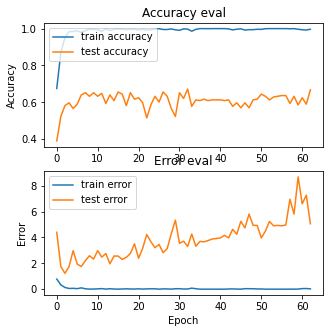

Correct Predictions: 13, incorrect predictions: 7
Starting 1
(2291, 128, 1292, 1)
(241, 128, 1292, 1)
(2291,)
(241,)
Epoch 1/200
287/287 [==============================] - 10s 34ms/step - loss: 0.7959 - accuracy: 0.6425 - val_loss: 1.4254 - val_accuracy: 0.7303
Epoch 2/200
287/287 [==============================] - 5s 18ms/step - loss: 0.3331 - accuracy: 0.8538 - val_loss: 0.7494 - val_accuracy: 0.6556
Epoch 3/200
287/287 [==============================] - 5s 18ms/step - loss: 0.1397 - accuracy: 0.9481 - val_loss: 1.1001 - val_accuracy: 0.5892
Epoch 4/200
287/287 [==============================] - 5s 18ms/step - loss: 0.1218 - accuracy: 0.9572 - val_loss: 1.2714 - val_accuracy: 0.5851
Epoch 5/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0403 - accuracy: 0.9873 - val_loss: 1.7777 - val_accuracy: 0.5394
Epoch 6/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 2.2028 - val_accuracy: 0.5353
Epoch 7/200
287/28

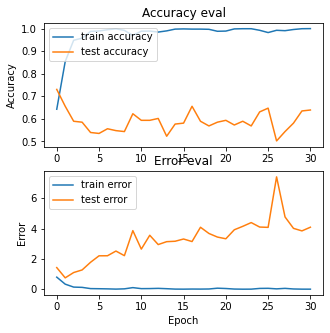

Correct Predictions: 14, incorrect predictions: 5
Starting 2
(2285, 128, 1292, 1)
(247, 128, 1292, 1)
(2285,)
(247,)
Epoch 1/200
286/286 [==============================] - 10s 35ms/step - loss: 0.8579 - accuracy: 0.6473 - val_loss: 6.0139 - val_accuracy: 0.4494
Epoch 2/200
286/286 [==============================] - 9s 31ms/step - loss: 0.3370 - accuracy: 0.8604 - val_loss: 0.8003 - val_accuracy: 0.6559
Epoch 3/200
286/286 [==============================] - 8s 30ms/step - loss: 0.1743 - accuracy: 0.9414 - val_loss: 0.8227 - val_accuracy: 0.6883
Epoch 4/200
286/286 [==============================] - 11s 39ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.7323 - val_accuracy: 0.7490
Epoch 5/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0599 - accuracy: 0.9838 - val_loss: 0.9476 - val_accuracy: 0.7368
Epoch 6/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0441 - accuracy: 0.9869 - val_loss: 1.4025 - val_accuracy: 0.6923
Epoch 7/200
286/2

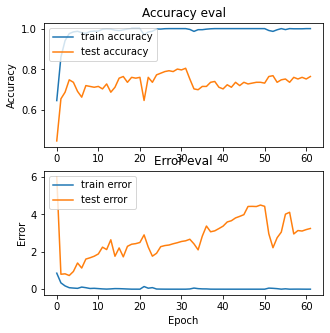

Correct Predictions: 16, incorrect predictions: 3
Starting 3
(2272, 128, 1292, 1)
(260, 128, 1292, 1)
(2272,)
(260,)
Epoch 1/200
284/284 [==============================] - 10s 36ms/step - loss: 0.7896 - accuracy: 0.6496 - val_loss: 1.2521 - val_accuracy: 0.5423
Epoch 2/200
284/284 [==============================] - 9s 30ms/step - loss: 0.3935 - accuracy: 0.8363 - val_loss: 0.9149 - val_accuracy: 0.5731
Epoch 3/200
284/284 [==============================] - 9s 31ms/step - loss: 0.2204 - accuracy: 0.9331 - val_loss: 1.1315 - val_accuracy: 0.6269
Epoch 4/200
284/284 [==============================] - 5s 17ms/step - loss: 0.1088 - accuracy: 0.9604 - val_loss: 1.6714 - val_accuracy: 0.6269
Epoch 5/200
284/284 [==============================] - 5s 17ms/step - loss: 0.0646 - accuracy: 0.9789 - val_loss: 2.0447 - val_accuracy: 0.5885
Epoch 6/200
284/284 [==============================] - 9s 32ms/step - loss: 0.0386 - accuracy: 0.9877 - val_loss: 1.9256 - val_accuracy: 0.6423
Epoch 7/200
284/28

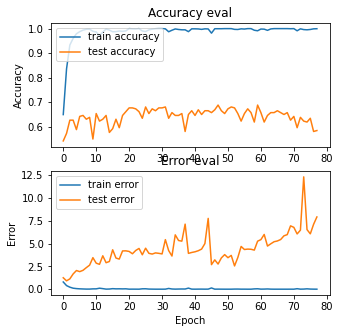

Correct Predictions: 14, incorrect predictions: 5
Starting 4
(2270, 128, 1292, 1)
(262, 128, 1292, 1)
(2270,)
(262,)
Epoch 1/200
284/284 [==============================] - 10s 36ms/step - loss: 0.8798 - accuracy: 0.6515 - val_loss: 2.8050 - val_accuracy: 0.5496
Epoch 2/200
284/284 [==============================] - 10s 34ms/step - loss: 0.3537 - accuracy: 0.8449 - val_loss: 0.7232 - val_accuracy: 0.5954
Epoch 3/200
284/284 [==============================] - 5s 18ms/step - loss: 0.1759 - accuracy: 0.9278 - val_loss: 1.1331 - val_accuracy: 0.5382
Epoch 4/200
284/284 [==============================] - 5s 18ms/step - loss: 0.1212 - accuracy: 0.9599 - val_loss: 1.6381 - val_accuracy: 0.5573
Epoch 5/200
284/284 [==============================] - 5s 18ms/step - loss: 0.1550 - accuracy: 0.9533 - val_loss: 1.7276 - val_accuracy: 0.5305
Epoch 6/200
284/284 [==============================] - 9s 32ms/step - loss: 0.0890 - accuracy: 0.9656 - val_loss: 1.2184 - val_accuracy: 0.6679
Epoch 7/200
284/2

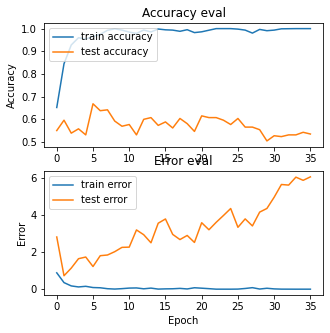

Correct Predictions: 12, incorrect predictions: 7
Starting 5
(2285, 128, 1292, 1)
(247, 128, 1292, 1)
(2285,)
(247,)
Epoch 1/200
286/286 [==============================] - 9s 32ms/step - loss: 0.8921 - accuracy: 0.6713 - val_loss: 1.0703 - val_accuracy: 0.4008
Epoch 2/200
286/286 [==============================] - 9s 31ms/step - loss: 0.3210 - accuracy: 0.8761 - val_loss: 0.9262 - val_accuracy: 0.5506
Epoch 3/200
286/286 [==============================] - 9s 30ms/step - loss: 0.1283 - accuracy: 0.9558 - val_loss: 1.2618 - val_accuracy: 0.6235
Epoch 4/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0473 - accuracy: 0.9895 - val_loss: 1.7177 - val_accuracy: 0.5870
Epoch 5/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0319 - accuracy: 0.9921 - val_loss: 2.0147 - val_accuracy: 0.6032
Epoch 6/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0358 - accuracy: 0.9908 - val_loss: 2.5059 - val_accuracy: 0.5911
Epoch 7/200
286/286

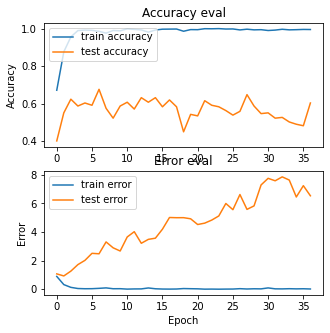

Correct Predictions: 13, incorrect predictions: 6
Starting 6
(2290, 128, 1292, 1)
(242, 128, 1292, 1)
(2290,)
(242,)
Epoch 1/200
287/287 [==============================] - 10s 36ms/step - loss: 0.8138 - accuracy: 0.6629 - val_loss: 4.2251 - val_accuracy: 0.3719
Epoch 2/200
287/287 [==============================] - 9s 31ms/step - loss: 0.3367 - accuracy: 0.8681 - val_loss: 0.6917 - val_accuracy: 0.6736
Epoch 3/200
287/287 [==============================] - 5s 18ms/step - loss: 0.1738 - accuracy: 0.9349 - val_loss: 1.0199 - val_accuracy: 0.6446
Epoch 4/200
287/287 [==============================] - 9s 33ms/step - loss: 0.1015 - accuracy: 0.9603 - val_loss: 1.1590 - val_accuracy: 0.7231
Epoch 5/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 1.4317 - val_accuracy: 0.7231
Epoch 6/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0381 - accuracy: 0.9865 - val_loss: 2.0329 - val_accuracy: 0.6322
Epoch 7/200
287/28

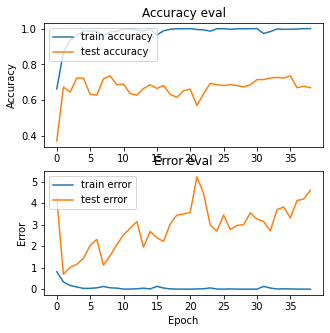

Correct Predictions: 15, incorrect predictions: 4
Starting 7
(2274, 128, 1292, 1)
(258, 128, 1292, 1)
(2274,)
(258,)
Epoch 1/200
285/285 [==============================] - 10s 35ms/step - loss: 0.7296 - accuracy: 0.6834 - val_loss: 0.8098 - val_accuracy: 0.4767
Epoch 2/200
285/285 [==============================] - 9s 31ms/step - loss: 0.2865 - accuracy: 0.8852 - val_loss: 1.3945 - val_accuracy: 0.5388
Epoch 3/200
285/285 [==============================] - 9s 32ms/step - loss: 0.1346 - accuracy: 0.9529 - val_loss: 1.2331 - val_accuracy: 0.6279
Epoch 4/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0580 - accuracy: 0.9815 - val_loss: 1.8530 - val_accuracy: 0.5891
Epoch 5/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0263 - accuracy: 0.9925 - val_loss: 2.5014 - val_accuracy: 0.5930
Epoch 6/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0619 - accuracy: 0.9793 - val_loss: 2.5790 - val_accuracy: 0.5426
Epoch 7/200
285/28

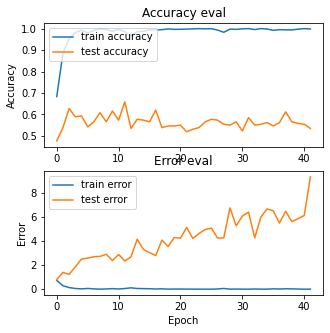

Correct Predictions: 13, incorrect predictions: 6
Starting 8
(2260, 128, 1292, 1)
(272, 128, 1292, 1)
(2260,)
(272,)
Epoch 1/200
283/283 [==============================] - 10s 37ms/step - loss: 0.7975 - accuracy: 0.6664 - val_loss: 2.7425 - val_accuracy: 0.5331
Epoch 2/200
283/283 [==============================] - 9s 32ms/step - loss: 0.3520 - accuracy: 0.8447 - val_loss: 1.1179 - val_accuracy: 0.5956
Epoch 3/200
283/283 [==============================] - 5s 18ms/step - loss: 0.1716 - accuracy: 0.9451 - val_loss: 2.0238 - val_accuracy: 0.5809
Epoch 4/200
283/283 [==============================] - 5s 18ms/step - loss: 0.1218 - accuracy: 0.9677 - val_loss: 2.3768 - val_accuracy: 0.5588
Epoch 5/200
283/283 [==============================] - 5s 19ms/step - loss: 0.0526 - accuracy: 0.9876 - val_loss: 3.0211 - val_accuracy: 0.5588
Epoch 6/200
283/283 [==============================] - 5s 18ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 3.3521 - val_accuracy: 0.5846
Epoch 7/200
283/28

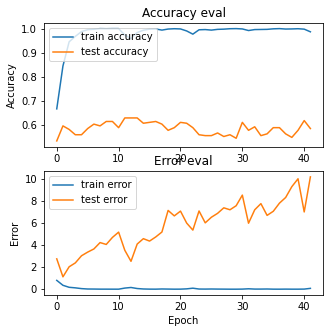

Correct Predictions: 14, incorrect predictions: 5
Starting 9
(2285, 128, 1292, 1)
(247, 128, 1292, 1)
(2285,)
(247,)
Epoch 1/200
286/286 [==============================] - 10s 33ms/step - loss: 0.8920 - accuracy: 0.6932 - val_loss: 0.6836 - val_accuracy: 0.6113
Epoch 2/200
286/286 [==============================] - 9s 31ms/step - loss: 0.2755 - accuracy: 0.8788 - val_loss: 0.8934 - val_accuracy: 0.6964
Epoch 3/200
286/286 [==============================] - 8s 29ms/step - loss: 0.1464 - accuracy: 0.9527 - val_loss: 1.0770 - val_accuracy: 0.7004
Epoch 4/200
286/286 [==============================] - 10s 36ms/step - loss: 0.0788 - accuracy: 0.9786 - val_loss: 1.5330 - val_accuracy: 0.7287
Epoch 5/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 1.6444 - val_accuracy: 0.6518
Epoch 6/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0458 - accuracy: 0.9869 - val_loss: 1.6734 - val_accuracy: 0.6721
Epoch 7/200
286/2

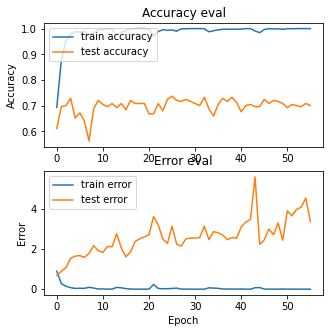

Correct Predictions: 13, incorrect predictions: 6


In [ ]:
maxes = []
for fold in range(0, 10):

  testSamples = splits[fold]['test']
  trainLength = 0
  testLength = 0
  ytrain = []
  ytest = []
  songSections = []
  songClassification = []


  # Calculates the size of train and test folds
  for i, (file) in enumerate(splits[fold]['train']):
    dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', file.replace(".mp3", "*"))
    clipSections = len(glob.glob(dir))
    trainLength+= clipSections
    if os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'noDJ', file)):
      ytrain_ = [0]*clipSections
    elif os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'yesDJ', file)):
      ytrain_ = [1]*clipSections
    else:
      print("Could not find file", file)
    ytrain = ytrain+ytrain_
  
  for i, (file) in enumerate(splits[fold]['test']):
    dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', file.replace(".mp3", "*"))
    clipSections = len(glob.glob(dir))
    testLength+= clipSections
    songSections.append(clipSections)
    if os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'noDJ', file)):
      ytest_ = [0]*clipSections
      songClassification.append(0)
    elif os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'yesDJ', file)):
      ytest_ = [1]*clipSections
      songClassification.append(1)
    else:
      print("Could not find file", file)

    ytest = ytest+ytest_
  
  # Create test/train data arrays

  x_train = np.ndarray((trainLength, 128, 1292), dtype=np.uint8)
  x_test = np.ndarray((testLength, 128, 1292), dtype=np.uint8)
  y_train = np.array(ytrain)
  y_test = np.array(ytest)

  # Load test/train data
  loc = 0
  for url in splits[fold]['train']:
    url = url.replace('.mp3', '')
    for loadpath in glob.glob(os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', url+'*.npy')):
      x_train[loc] = np.load(loadpath)
      loc+=1
  x_train = x_train.astype('float32')
  x_train = x_train.astype('float32')
  mean = np.mean(x_train)
  std = np.mean(x_train)
  x_train -= mean
  x_train /= std
  x_train = x_train[..., np.newaxis]

  loc = 0
  for url in splits[fold]['test']:
    url = url.replace('.mp3', '')
    for loadpath in glob.glob(os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', url+'*.npy')):
      x_test[loc] = np.load(loadpath)
      loc+=1
  x_test = x_test.astype('float32')
  x_test = x_test.astype('float32')
  mean = np.mean(x_test)
  std = np.mean(x_test)
  x_test -= mean
  x_test /= std
  x_test = x_test[..., np.newaxis]

  print(f"Starting {fold}")
  model = run_cnn(x_train, x_test, y_train, y_test)

  # Ensemble voting
  start = 0
  predictions = np.argmax(model.predict(x_test), axis=1)
  ensemblePrediction = []
  for song in range(0, len(songClassification)):
    correct = 0
    incorrect = 0

    for i, j in zip(y_test[start:start+songSections[song]], predictions[start:start+songSections[song]]):
      if i==j==songClassification[song]:
        correct+=1
    # print(f"{correct} {songSections[song]}")
    start=start+songSections[song]
    ensemblePrediction.append(correct/songSections[song])


  correctPreds = 0
  incorrectPreds = 0
  for i in ensemblePrediction:
    if i >= .50:
      correctPreds+=1
    else:
      incorrectPreds+=1

  print(f"Correct Predictions: {correctPreds}, incorrect predictions: {incorrectPreds}")

  # maxes.append(m)
# avg = sum(maxes)/len(maxes)
# std = statistics.stdev(maxes)
# print(f"AVG: {avg} STD: {std} ")


In [ ]:
ensemblePrediction

[0.8571428571428571,
 0.6428571428571429,
 0.0,
 0.8125,
 0.5833333333333334,
 0.8181818181818182,
 0.6666666666666666,
 0.3333333333333333,
 0.75,
 0.8,
 0.35714285714285715,
 0.7857142857142857,
 0.8888888888888888,
 0.8666666666666667,
 0.8333333333333334,
 1.0,
 0.3333333333333333,
 0.4375,
 1.0,
 0.14285714285714285]

In [ ]:
correctPreds = 0
incorrectPreds = 0
for i in ensemblePrediction:
  if i > .50:
    correctPreds+=1
  else:
    incorrectPreds+=1

print(f"Correct Predictions: {correctPreds}, incorrect predictions: {incorrectPreds}")

Correct Predictions: 15, incorrect predictions: 5


In [ ]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

3ATxO8JsG7o.mp3_MFCC_20_1024_1024.npy
MRDyOaCJ3t0.mp3_MFCC_20_1024_1024.npy
gGblVzPZhQs.mp3_MFCC_20_1024_1024.npy
RfQVJx5cJ-w.mp3_MFCC_20_1024_1024.npy
TTk3a4mjE_o.mp3_MFCC_20_1024_1024.npy
C5VCCwvxOh0.mp3_MFCC_20_1024_1024.npy
SuFaCxIhgGg.mp3_MFCC_20_1024_1024.npy
CYvF2VIfKck.mp3_MFCC_20_1024_1024.npy
tYJTjsD86qo.mp3_MFCC_20_1024_1024.npy
nl17mFG7if4.mp3_MFCC_20_1024_1024.npy
L_sq91YLuK8.mp3_MFCC_20_1024_1024.npy
ygd_i9F9X9w.mp3_MFCC_20_1024_1024.npy
CF4UFimvp3E.mp3_MFCC_20_1024_1024.npy
TtjVXqGfoU4.mp3_MFCC_20_1024_1024.npy
qRy7c851C2A.mp3_MFCC_20_1024_1024.npy
A-zDtfeowoI.mp3_MFCC_20_1024_1024.npy
DO21jwbhXaQ.mp3_MFCC_20_1024_1024.npy
4_w2TjslZtU.mp3_MFCC_20_1024_1024.npy
OpTIzD5Drhc.mp3_MFCC_20_1024_1024.npy
9CzMlAJNdwQ.mp3_MFCC_20_1024_1024.npy
Starting 0
(171, 3876, 13, 1)
(20, 3876, 13, 1)
(171,)
(20,)
Epoch 1/200
22/22 [==============================] - 0s 19ms/step - loss: 1.1553 - accuracy: 0.5263 - val_loss: 0.7046 - val_accuracy: 0.3000
Epoch 2/200
22/22 [==================

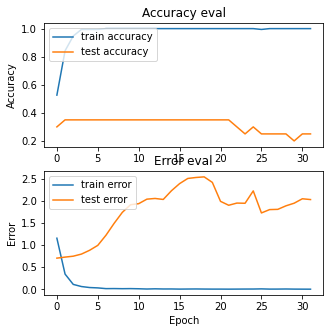

ng2ITXrO6pg.mp3_MFCC_20_1024_1024.npy
5l8QTbrwY5w.mp3_MFCC_20_1024_1024.npy
bpeb5TkqAqQ.mp3_MFCC_20_1024_1024.npy
WZYTsNgLagQ.mp3_MFCC_20_1024_1024.npy
1_hjtOPJsN0.mp3_MFCC_20_1024_1024.npy
9CfNwg7h-Bo.mp3_MFCC_20_1024_1024.npy
Yd7lh4Inn-A.mp3_MFCC_20_1024_1024.npy
N83Rzpc0lyg.mp3_MFCC_20_1024_1024.npy
khl-Ky_TnhA.mp3_MFCC_20_1024_1024.npy
Kt6LkBTCWZc.mp3_MFCC_20_1024_1024.npy
So60yQpn9WQ.mp3_MFCC_20_1024_1024.npy
rlEjXlx8K9M.mp3_MFCC_20_1024_1024.npy
CQ7iJ45pG3Y.mp3_MFCC_20_1024_1024.npy
6VazI-HFH2Q.mp3_MFCC_20_1024_1024.npy
5tHN3pVaYP0.mp3_MFCC_20_1024_1024.npy
4dMnqJWeRMM.mp3_MFCC_20_1024_1024.npy
MK7F2elY68o.mp3_MFCC_20_1024_1024.npy
O8kBH2ygee0.mp3_MFCC_20_1024_1024.npy
RO4DioevdoU.mp3_MFCC_20_1024_1024.npy
Starting 1
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 17ms/step - loss: 1.2859 - accuracy: 0.4360 - val_loss: 0.7583 - val_accuracy: 0.2632
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

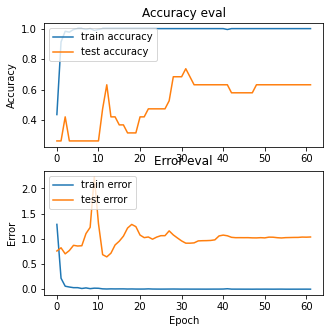

PnGQXboJNZ8.mp3_MFCC_20_1024_1024.npy
xs1yk1h2Z6Q.mp3_MFCC_20_1024_1024.npy
F5P48NA9fHc.mp3_MFCC_20_1024_1024.npy
ho2bcsdDp_8.mp3_MFCC_20_1024_1024.npy
VfWBGh8_8Wk.mp3_MFCC_20_1024_1024.npy
uwOlqQ1mXxA.mp3_MFCC_20_1024_1024.npy
TMfsrvEiqfw.mp3_MFCC_20_1024_1024.npy
ACfRckL_15Y.mp3_MFCC_20_1024_1024.npy
6ylEDDh8hbM.mp3_MFCC_20_1024_1024.npy
Qorso5c526M.mp3_MFCC_20_1024_1024.npy
tidM5EnR7Qc.mp3_MFCC_20_1024_1024.npy
xvPZptuT6bk.mp3_MFCC_20_1024_1024.npy
bODW6UHR9YU.mp3_MFCC_20_1024_1024.npy
E5tTzHgkVjg.mp3_MFCC_20_1024_1024.npy
txk4QsnWHhU.mp3_MFCC_20_1024_1024.npy
FTWAhUZRxd0.mp3_MFCC_20_1024_1024.npy
7yh1uJ7ayBA.mp3_MFCC_20_1024_1024.npy
S6PBF8fshJs.mp3_MFCC_20_1024_1024.npy
w0dQK4_llDI.mp3_MFCC_20_1024_1024.npy
Starting 2
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 13ms/step - loss: 1.1523 - accuracy: 0.5000 - val_loss: 0.6831 - val_accuracy: 0.5789
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

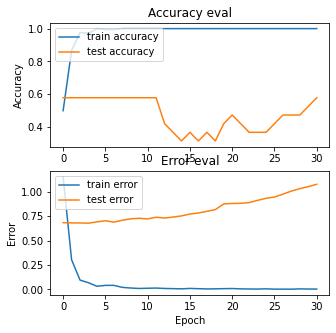

chmxNp92JAA.mp3_MFCC_20_1024_1024.npy
2DQCWH6nZGo.mp3_MFCC_20_1024_1024.npy
MgM92tbQVKQ.mp3_MFCC_20_1024_1024.npy
uKnfaA1VYSI.mp3_MFCC_20_1024_1024.npy
8pDfITIxo4A.mp3_MFCC_20_1024_1024.npy
jaJnTxo8WrY.mp3_MFCC_20_1024_1024.npy
JCaAQoawp_0.mp3_MFCC_20_1024_1024.npy
2jDS6VfbNTU.mp3_MFCC_20_1024_1024.npy
_ingzZSBWwQ.mp3_MFCC_20_1024_1024.npy
Zbby-hfG67k.mp3_MFCC_20_1024_1024.npy
zoeSnMAviO8.mp3_MFCC_20_1024_1024.npy
5hkYuaZdnKU.mp3_MFCC_20_1024_1024.npy
0IMU4GAQe4w.mp3_MFCC_20_1024_1024.npy
fDbI40SJ7zI.mp3_MFCC_20_1024_1024.npy
Lw07PJU3WH4.mp3_MFCC_20_1024_1024.npy
yf8VArzNYV4.mp3_MFCC_20_1024_1024.npy
RNauJctY9Ng.mp3_MFCC_20_1024_1024.npy
WbAR--Hz094.mp3_MFCC_20_1024_1024.npy
vsk9T1psako.mp3_MFCC_20_1024_1024.npy
Starting 3
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 12ms/step - loss: 1.1225 - accuracy: 0.4709 - val_loss: 0.6985 - val_accuracy: 0.4737
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

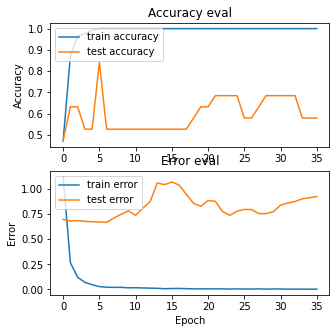

uyLGCNkSgmk.mp3_MFCC_20_1024_1024.npy
RS8Iij38HuM.mp3_MFCC_20_1024_1024.npy
0-MxidypKwI.mp3_MFCC_20_1024_1024.npy
AwHBTnb-WQQ.mp3_MFCC_20_1024_1024.npy
scDul_mI4uc.mp3_MFCC_20_1024_1024.npy
FB7QJbawDU8.mp3_MFCC_20_1024_1024.npy
VgQYK6Gj410.mp3_MFCC_20_1024_1024.npy
OC3gRZBGM90.mp3_MFCC_20_1024_1024.npy
RuN7o9ay20c.mp3_MFCC_20_1024_1024.npy
C4jEVe5McRE.mp3_MFCC_20_1024_1024.npy
FGNIz2z26MM.mp3_MFCC_20_1024_1024.npy
xFQdy6vLhbk.mp3_MFCC_20_1024_1024.npy
k-TsLvRLaiI.mp3_MFCC_20_1024_1024.npy
eT2cafWD3Rs.mp3_MFCC_20_1024_1024.npy
pLy5oAMhQrU.mp3_MFCC_20_1024_1024.npy
jxAdEJCJddo.mp3_MFCC_20_1024_1024.npy
25NYAVvPvl4.mp3_MFCC_20_1024_1024.npy
uOO7inqjLZQ.mp3_MFCC_20_1024_1024.npy
slnsCDoMInk.mp3_MFCC_20_1024_1024.npy
Starting 4
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 13ms/step - loss: 1.1127 - accuracy: 0.4419 - val_loss: 0.6974 - val_accuracy: 0.4737
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

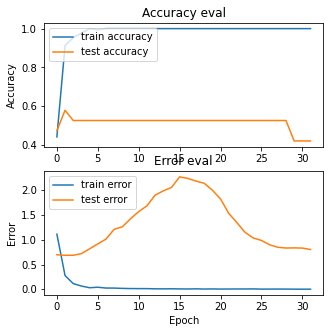

xmVHj0fITEc.mp3_MFCC_20_1024_1024.npy
i5OUJv8lrYw.mp3_MFCC_20_1024_1024.npy
H4iZ8lpBZ7s.mp3_MFCC_20_1024_1024.npy
R13pIiQ7PLc.mp3_MFCC_20_1024_1024.npy
OoJ7oh-ZliM.mp3_MFCC_20_1024_1024.npy
PQRURlIn0-c.mp3_MFCC_20_1024_1024.npy
JBjAZ9VxgPE.mp3_MFCC_20_1024_1024.npy
MGCic_4K3pc.mp3_MFCC_20_1024_1024.npy
4q2OQBC7sFc.mp3_MFCC_20_1024_1024.npy
IDyFQEXYrYs.mp3_MFCC_20_1024_1024.npy
MIQUTdFEXVw.mp3_MFCC_20_1024_1024.npy
GuukGT193Ec.mp3_MFCC_20_1024_1024.npy
aFGNk2ilFfI.mp3_MFCC_20_1024_1024.npy
Sun0F8MgJKU.mp3_MFCC_20_1024_1024.npy
p8OCU9dgHGw.mp3_MFCC_20_1024_1024.npy
m6GMCcCHrfM.mp3_MFCC_20_1024_1024.npy
9x3MUdnLaL0.mp3_MFCC_20_1024_1024.npy
tmjN49jEDzQ.mp3_MFCC_20_1024_1024.npy
ajBiuKu-1YQ.mp3_MFCC_20_1024_1024.npy
Starting 5
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 13ms/step - loss: 1.0928 - accuracy: 0.5465 - val_loss: 0.8122 - val_accuracy: 0.3684
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

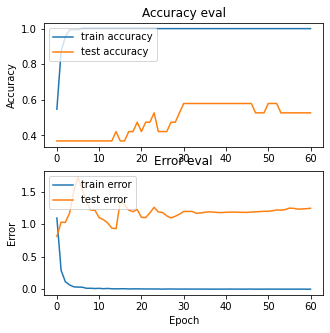

d1oJcAP8OGg.mp3_MFCC_20_1024_1024.npy
fkEmZyQzYrw.mp3_MFCC_20_1024_1024.npy
ZqAqD-yjY4Y.mp3_MFCC_20_1024_1024.npy
iWMXPJcM0T0.mp3_MFCC_20_1024_1024.npy
6Wo_s1i13y0.mp3_MFCC_20_1024_1024.npy
7373VBAN9eU.mp3_MFCC_20_1024_1024.npy
6MfdjuzcPJA.mp3_MFCC_20_1024_1024.npy
0TLkXhem5Yk.mp3_MFCC_20_1024_1024.npy
5WlLvB4ONL8.mp3_MFCC_20_1024_1024.npy
TyS0XeenZK0.mp3_MFCC_20_1024_1024.npy
3ZUbkEGdzT0.mp3_MFCC_20_1024_1024.npy
4sj4a7XA--M.mp3_MFCC_20_1024_1024.npy
p8f7gSg96Go.mp3_MFCC_20_1024_1024.npy
QvtENC8XqR0.mp3_MFCC_20_1024_1024.npy
kID6J6Z436M.mp3_MFCC_20_1024_1024.npy
IRnl746GIuo.mp3_MFCC_20_1024_1024.npy
0ABA9tIqCCo.mp3_MFCC_20_1024_1024.npy
bn0x8fE3yV4.mp3_MFCC_20_1024_1024.npy
KOKfkSV-esU.mp3_MFCC_20_1024_1024.npy
Starting 6
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 13ms/step - loss: 1.1512 - accuracy: 0.5349 - val_loss: 0.6870 - val_accuracy: 0.6316
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

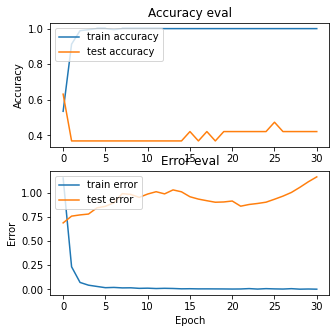

mbLr0eqRoHM.mp3_MFCC_20_1024_1024.npy
ux6LF6DsNwU.mp3_MFCC_20_1024_1024.npy
uswZNW9c7eY.mp3_MFCC_20_1024_1024.npy
2DYJPj9flBk.mp3_MFCC_20_1024_1024.npy
LQ_H6vW_QF8.mp3_MFCC_20_1024_1024.npy
lsxVuJyIglQ.mp3_MFCC_20_1024_1024.npy
pPdtNywAouE.mp3_MFCC_20_1024_1024.npy
zk_WEuA2WTE.mp3_MFCC_20_1024_1024.npy
wpbzhFrauM4.mp3_MFCC_20_1024_1024.npy
hMkLcaydkaE.mp3_MFCC_20_1024_1024.npy
lzBkAB5mMKQ.mp3_MFCC_20_1024_1024.npy
lN68amaLAic.mp3_MFCC_20_1024_1024.npy
oh6Z6kp8r9Q.mp3_MFCC_20_1024_1024.npy
lOOtaHiTsus.mp3_MFCC_20_1024_1024.npy
YEefSuF9UaU.mp3_MFCC_20_1024_1024.npy
Lo0ELoepTCM.mp3_MFCC_20_1024_1024.npy
3awn-74uJzw.mp3_MFCC_20_1024_1024.npy
U94QuYfcOBw.mp3_MFCC_20_1024_1024.npy
sy8bUrGA4Ao.mp3_MFCC_20_1024_1024.npy
Starting 7
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 12ms/step - loss: 1.8463 - accuracy: 0.4942 - val_loss: 0.7134 - val_accuracy: 0.4211
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

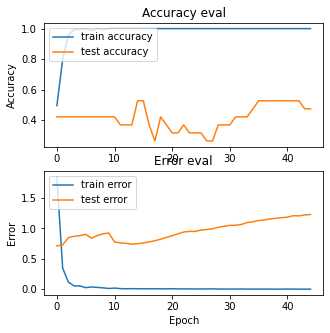

TDhrMxdDOeg.mp3_MFCC_20_1024_1024.npy
_0bgwAkpp0Y.mp3_MFCC_20_1024_1024.npy
QQf1e7H0_oY.mp3_MFCC_20_1024_1024.npy
DREDfpV4k3w.mp3_MFCC_20_1024_1024.npy
btz2Cf96Jic.mp3_MFCC_20_1024_1024.npy
aL-LqBupgIY.mp3_MFCC_20_1024_1024.npy
iYzwxFD0rEM.mp3_MFCC_20_1024_1024.npy
CzxRwRGhXEs.mp3_MFCC_20_1024_1024.npy
zUp4y5aScM0.mp3_MFCC_20_1024_1024.npy
PE5luMsuiv8.mp3_MFCC_20_1024_1024.npy
VUK6i3BwBrQ.mp3_MFCC_20_1024_1024.npy
xPCfk0ytc-M.mp3_MFCC_20_1024_1024.npy
Q6jyQmu_79U.mp3_MFCC_20_1024_1024.npy
tA53ehjOVwY.mp3_MFCC_20_1024_1024.npy
xQf3O9hfVrM.mp3_MFCC_20_1024_1024.npy
Kd9g3LQ9eRs.mp3_MFCC_20_1024_1024.npy
RuzS27rZIDU.mp3_MFCC_20_1024_1024.npy
9IBDq493aEI.mp3_MFCC_20_1024_1024.npy
y2gQSzJBA_Y.mp3_MFCC_20_1024_1024.npy
Starting 8
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 13ms/step - loss: 1.1220 - accuracy: 0.4651 - val_loss: 0.6899 - val_accuracy: 0.5263
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

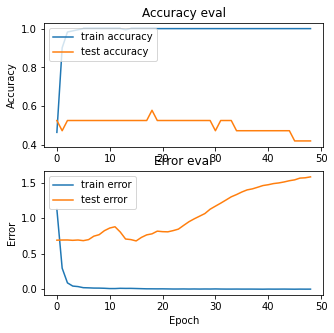

u1Us17LmPSM.mp3_MFCC_20_1024_1024.npy
b90kUR7SivU.mp3_MFCC_20_1024_1024.npy
VMImzySFRA8.mp3_MFCC_20_1024_1024.npy
nEuzSuNCA4s.mp3_MFCC_20_1024_1024.npy
W_eEWyAZAqM.mp3_MFCC_20_1024_1024.npy
4VqYIIqSgIU.mp3_MFCC_20_1024_1024.npy
iVUKfRyu-LA.mp3_MFCC_20_1024_1024.npy
udiEEyHnZnc.mp3_MFCC_20_1024_1024.npy
b5o9XlYWeUg.mp3_MFCC_20_1024_1024.npy
YumRXySoBGc.mp3_MFCC_20_1024_1024.npy
6jx1pTxuGp8.mp3_MFCC_20_1024_1024.npy
vBAhXU9dxro.mp3_MFCC_20_1024_1024.npy
9kcxwCrzSFU.mp3_MFCC_20_1024_1024.npy
rV3dCjKiIrg.mp3_MFCC_20_1024_1024.npy
RyqepS2BKUI.mp3_MFCC_20_1024_1024.npy
uX-dWSLyOUs.mp3_MFCC_20_1024_1024.npy
Ou0P7kHGp1c.mp3_MFCC_20_1024_1024.npy
RaPwDIk2jXs.mp3_MFCC_20_1024_1024.npy
AEVY_u1HDwA.mp3_MFCC_20_1024_1024.npy
Starting 9
(172, 3876, 13, 1)
(19, 3876, 13, 1)
(172,)
(19,)
Epoch 1/200
22/22 [==============================] - 0s 12ms/step - loss: 1.4939 - accuracy: 0.4942 - val_loss: 0.7249 - val_accuracy: 0.4211
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.

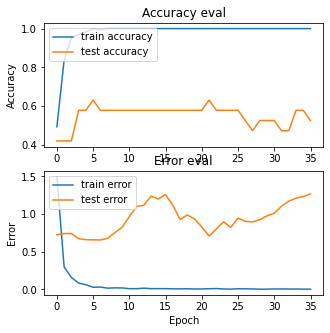

AVG: 0.6034210473299026 STD: 0.12863400211473758 


In [ ]:
maxes = []

for i in range(0, 10):
  num_train = len(splits[i]['train'])
  num_test = len(splits[i]['test'])

  x_train = np.ndarray((num_train, 3876, 13))
  x_test = np.ndarray((num_test, 3876, 13))
  y_train = np.array(splits[i]['ytrain'])
  y_test = np.array(splits[i]['ytest'])

  for j, url in enumerate(splits[i]['test']):
    file = url+'_MFCC_20_1024_1024.npy'
    print(file)
    loadpath = os.path.join(BASE, DATA_SAVE_PATH, 'MFCC', file)
    data = np.load(loadpath)
    data = data[:, :13]
    
    x_test[j] = data

  x_test = x_test[..., np.newaxis]

  for j, url in enumerate(splits[i]['train']):
    file = url+'_MFCC_20_1024_1024.npy'
    loadpath = os.path.join(BASE, DATA_SAVE_PATH, 'MFCC', file)
    data = np.load(loadpath)
    data = data[:, :13]
    x_train[j] = data
    
  x_train = x_train[..., np.newaxis]
  print(f"Starting {i}")
  m = run_cnn(x_train, x_test, y_train, y_test)
  maxes.append(m)
avg = sum(maxes)/len(maxes)
std = statistics.stdev(maxes)
print(f"AVG: {avg} STD: {std} ")

In [ ]:
m1 = [0.6499999761581421, 0.7368420958518982, 0.6315789222717285, 0.7368420958518982, 0.6842105388641357]
m2 = [0.6842105388641357, 0.6315789222717285, 0.5789473652839661, 0.7894737124443054, 0.7368420958518982]
maxes = m1+m2

In [ ]:
avg = sum(maxes)/len(maxes)
print(avg)
print(statistics.stdev(maxes))

0.6860526263713836
0.06424563769391797


In [ ]:
maxes

{'MFCC_13_nfft_1024_hl_256': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'avg': 1.0,
 'std': 0.0}

In [ ]:
maxes

{'MFCC_16_nfft_2048_hl_256': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'avg': 1.0,
 'std': 0.0}

In [ ]:
l=[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.550000011920929]
sum(l)/len(l)
# statistics.stdev(l)

0.9550000011920929

In [ ]:
X_train = data['X_train']
X_test = data['X_test']
y_test = data['y_test']
y_train = data['y_train']